In [1]:
# update gdown, used to download stuff from google drive
!pip install -q --upgrade gdown

In [2]:
# download dataset
!gdown -q -O dataset.zip 1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT

In [3]:
# unzip dataset
!unzip -q -o dataset.zip

In [4]:
import pathlib

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import tensorflow as tf
import skimage

from loguru import logger
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

DAEDALUS2_DIR = pathlib.Path(
    "/workspaces/python_playground/playground/daedalus/daedalus2"
)

TRAIN_DATASET_DIR = DAEDALUS2_DIR / "post-processed"
TRAIN_DATASET_IMAGE_SIZE = (112, 112)
TRAIN_DATASET_CLASS_COUNT = 2996
TRAIN_BATCH_SIZE = 256

DATABASE_DIR = DAEDALUS2_DIR / "features_database"
MODEL_WEIGHTS_PATH = DAEDALUS2_DIR / "feature_extractor" / "weights"
FEATURE_VECTOR_SIZE = 128

MARQUINHO_TRAIN_IMAGE_PATH = DAEDALUS2_DIR / "marquinho_train.jpg"
MARQUINHO_TEST_IMAGE_PATH = DAEDALUS2_DIR / "marquinho_test.jpg"

RNG_SEED = 42

# ensure directories exist
assert TRAIN_DATASET_DIR.exists()
MODEL_WEIGHTS_PATH.parent.mkdir(parents=True, exist_ok=True)


In [5]:
def check_if_images_have_same_shape(
    dataset_dir: pathlib.Path = TRAIN_DATASET_DIR,
) -> None:
    paths = dataset_dir.rglob("*.jpg")
    imgs = [cv2.imread(str(p)) for p in paths]
    shapes = [img.shape for img in imgs]
    return np.all(np.asarray(shapes)), shapes[0]


# check_if_images_have_same_shape()


# Train feature extractor

In [6]:
def load_dataset(
    dataset_dir: pathlib.Path = TRAIN_DATASET_DIR,
    rng_seed: int = RNG_SEED,
    batch_size: int = TRAIN_BATCH_SIZE,
) -> tf.data.Dataset:
    ds = tf.keras.utils.image_dataset_from_directory(
        directory=dataset_dir,
        batch_size=None,
        image_size=TRAIN_DATASET_IMAGE_SIZE,
        label_mode="categorical",
    )

    return (
        ds.map(lambda d, t: (tf.keras.applications.resnet_v2.preprocess_input(d), t))
        .cache()
        .shuffle(
            buffer_size=ds.cardinality().numpy(),
            seed=rng_seed,
            reshuffle_each_iteration=True,
        )
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
    )


load_dataset().element_spec


Found 12000 files belonging to 2996 classes.


2023-03-10 16:38:29.066065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:38:29.451511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46712 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6


(TensorSpec(shape=(256, 112, 112, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 2996), dtype=tf.float32, name=None))

In [7]:
def create_models() -> tf.keras.Model:
    base = tf.keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=TRAIN_DATASET_IMAGE_SIZE + (3,),
        include_top=False,
    )

    for layer in base.layers:
        layer.trainable = False

    augmented_input = tf.keras.Input(shape=TRAIN_DATASET_IMAGE_SIZE + (3,))

    data_aug = tf.keras.layers.RandomFlip(mode="horizontal")(augmented_input)
    data_aug = tf.keras.layers.RandomRotation(factor=15.0 / 360)(data_aug)
    data_aug = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(data_aug)

    base_model_out = base(data_aug)

    # the arch is not particularly important
    flatten = tf.keras.layers.Flatten()(base_model_out)
    dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
    dense1 = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
    dense2 = tf.keras.layers.BatchNormalization()(dense2)

    # we want the values to be between 0, 1
    extractor_output = tf.keras.layers.Dense(FEATURE_VECTOR_SIZE, activation="sigmoid")(dense2)

    feature_extractor = tf.keras.Model(
        inputs=augmented_input,
        outputs=extractor_output,
        name="feature_extractor",
    )

    softmax = tf.keras.layers.Dense(TRAIN_DATASET_CLASS_COUNT, "softmax")(extractor_output)
    classifier = tf.keras.Model(
        inputs=augmented_input,
        outputs=softmax,
        name="classifier",
    )

    classifier.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics="accuracy",
    )

    return feature_extractor, classifier


In [8]:
def load_or_create_feature_extractor(
    train_dataset_dir: pathlib.Path = TRAIN_DATASET_DIR,
    model_weights_path: pathlib.Path = MODEL_WEIGHTS_PATH,
) -> tf.keras.Model:
    feature_extractor, classifier = create_models()

    try:
        classifier.load_weights(model_weights_path).expect_partial()
    except tf.errors.NotFoundError:
        ds = load_dataset(dataset_dir=train_dataset_dir)
        classifier.fit(ds, epochs=999, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)])
        classifier.save_weights(model_weights_path, save_format="tf")

    return feature_extractor

load_or_create_feature_extractor()

# Feature extraction, assumes the model was trained already

In [9]:
def extract_features_vector(
    image: npt.NDArray[np.float32],
    feature_extractor: tf.keras.Model,
) -> npt.NDArray[np.float32]:
    
    if image.shape == TRAIN_DATASET_IMAGE_SIZE + (3,):
        fixed_size = image
    else:
        fixed_size = cv2.resize(image, TRAIN_DATASET_IMAGE_SIZE)
    
    preprocessed = tf.keras.applications.resnet_v2.preprocess_input(fixed_size)
    batched = preprocessed.reshape(1, *preprocessed.shape)
    return feature_extractor.predict(batched).flatten()

In [10]:
def add_new_instance_to_database(
    image: npt.NDArray[np.float32],
    instance_label: str,
    instance_id: str,
    database_dir: pathlib.Path,
    feature_extractor: tf.keras.Model,
) -> None:
    """
    `instance_path`: path to the image to be added to the database
    `instance_label`: the name or identifier of the the instance
    `database_dir`: location of the database
    `feature_extractor`: a pre-trained neural network that generated feature vectors
    """

    logger.info(f"storing new instance, label={instance_label}, instance_id={instance_id}")

    feature_vector = extract_features_vector(
        image=image,
        feature_extractor=feature_extractor,
    )

    # create, if necessary, the label dir
    label_dir = database_dir / instance_label
    label_dir.mkdir(parents=True, exist_ok=True)

    features_vector_path =(label_dir / instance_id).with_suffix(".npy")
    if features_vector_path.exists():
        logger.warning(
            "there is already an instance with this instance_id in the database, overwriting"
        )

    np.save(
        file=features_vector_path,
        arr=feature_vector,
    )


In [11]:
def populate_database_with_train_dataset(
    feature_extractor: tf.keras.Model,
    train_dataset_dir: pathlib.Path = TRAIN_DATASET_DIR,
    database_dir: pathlib.Path = DATABASE_DIR,
) -> None:
    for label_dir in train_dataset_dir.iterdir():
        for image_path in label_dir.iterdir():
            add_new_instance_to_database(
                image=cv2.imread(str(image_path)),
                instance_label=label_dir.name,
                instance_id=image_path.stem,
                database_dir=database_dir,
                feature_extractor=feature_extractor,
            )


# populate_database_with_train_dataset(
#     feature_extractor=load_or_create_feature_extractor()
# )


2023-03-10 16:38:34.070 | INFO     | __main__:add_new_instance_to_database:15 - storing new instance, label=Vitali_Klitschko, instance_id=Vitali_Klitschko_0003_0001
2023-03-10 16:38:35.336783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2023-03-10 16:38:36.719444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-10 16:38:36.870 | WARNING  | __main__:add_new_instance_to_database:28 - there is already an instance with this instance_id in the database, overwriting
2023-03-10 16:38:36.872 | INFO     | __main__:add_new_instance_to_database:15 - storing new instance, label=Vitali_Klitschko, instance_id=Vitali_Klitschko_0003_0000
2023-03-10 16:38:36.965 | WARNING  | __main__:add_new_instance_to_database:28 - there is already an instance with this instance_id in the database, overwriting
2023-03-10 16:38:36.967 | INFO     | __main__:add_new_instance_to_database

# Adding new instances

In [12]:
def add_new_instance_to_database_with_augmentations(
    image_path: pathlib.Path,
    label: str,
    feature_extractor: tf.keras.Model,
    database_dir: pathlib.Path = DATABASE_DIR,
) -> None:
    original_image = cv2.imread(str(image_path))
    add_new_instance_to_database(
            image=original_image,
            instance_label=label,
            instance_id=image_path.stem,
            database_dir=database_dir,
            feature_extractor=feature_extractor,
        )

    algumentatinator = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15),
        ]
    )

    for i in range(16):
        augmented = algumentatinator(image=original_image)
        add_new_instance_to_database(
                image=augmented["image"],
                instance_label=label,
                instance_id=f"{image_path.stem}_aug{i}",
                database_dir=database_dir,
                feature_extractor=feature_extractor
        )



In [13]:
def create_label_encoder(database_dir: pathlib.Path = DATABASE_DIR) -> LabelEncoder:
    label_dirs = sorted(database_dir.iterdir())
    label_names = [path.name for path in label_dirs]
    return LabelEncoder().fit(label_names)


In [14]:
def load_feature_vectors_and_labels(
    database_dir: pathlib.Path = DATABASE_DIR,
) -> tuple[npt.NDArray[np.float32], npt.NDArray[np.int64]]:
    paths = list(database_dir.rglob("*.npy"))

    features = np.array([np.load(p) for p in paths])

    label_encoder = create_label_encoder(database_dir)
    labels = [p.parent.name for p in paths]
    encoded_labels = label_encoder.transform(labels)
    
    return features, encoded_labels

def _check_load_feature_vectors_and_labels() -> None:
    features, labels = load_feature_vectors_and_labels()
    print(features.shape, features.dtype)
    print(labels.shape, labels.dtype)

# _check_load_feature_vectors_and_labels()

In [15]:
def classify_instance(
    instance_path: pathlib.Path,
    feature_extractor: tf.keras.Model,
) -> int:
    database_features, database_labels = load_feature_vectors_and_labels()
    model = KNeighborsClassifier(weights="distance").fit(database_features, database_labels)

    img = cv2.imread(str(instance_path))
    resized_img = cv2.resize(img, TRAIN_DATASET_IMAGE_SIZE)
    preprocessed = tf.keras.applications.resnet_v2.preprocess_input(resized_img)
    batched_image = preprocessed.reshape(1, *preprocessed.shape)
    instance_features = feature_extractor.predict(batched_image).flatten()

    return model.predict([instance_features])

In [16]:
!gdown -q -O marquinho_train.jpg "1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb"
!gdown -q -O marquinho_test.jpg "1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW"

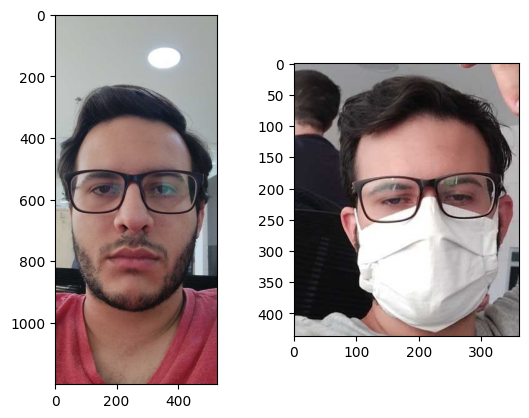

In [28]:
%matplotlib inline

def show_marquinho():
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(skimage.io.imread(DAEDALUS2_DIR / 'marquinho_train.jpg'))
    ax[1].imshow(skimage.io.imread(DAEDALUS2_DIR / 'marquinho_test.jpg'))
    plt.show(fig)

show_marquinho()


In [29]:
add_new_instance_to_database_with_augmentations(
    image_path=MARQUINHO_TRAIN_IMAGE_PATH,
    label="marquinho",
    feature_extractor=load_or_create_feature_extractor(),
    database_dir=DATABASE_DIR,
)

expeced_label = create_label_encoder().transform(["marquinho"])
predicted_label = classify_instance(MARQUINHO_TEST_IMAGE_PATH, load_or_create_feature_extractor())

print(expeced_label, predicted_label)

2023-03-10 17:00:02.865 | INFO     | __main__:add_new_instance_to_database:15 - storing new instance, label=marquinho, instance_id=marquinho_train
2023-03-10 17:00:03.542 | WARNING  | __main__:add_new_instance_to_database:28 - there is already an instance with this instance_id in the database, overwriting
2023-03-10 17:00:03.547 | INFO     | __main__:add_new_instance_to_database:15 - storing new instance, label=marquinho, instance_id=marquinho_train_aug0
2023-03-10 17:00:03.601 | WARNING  | __main__:add_new_instance_to_database:28 - there is already an instance with this instance_id in the database, overwriting
2023-03-10 17:00:03.605 | INFO     | __main__:add_new_instance_to_database:15 - storing new instance, label=marquinho, instance_id=marquinho_train_aug1
2023-03-10 17:00:03.660 | WARNING  | __main__:add_new_instance_to_database:28 - there is already an instance with this instance_id in the database, overwriting
2023-03-10 17:00:03.665 | INFO     | __main__:add_new_instance_to_dat

[2996] [2996]
